In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvutils.visualize import display_images
from celldom.core import cytometry
from celldom.core.experiment import Experiment
from celldom.config.experiment_config import ExperimentConfig
config_path = '/lab/repos/celldom/config/experiment/exp-20181121-ML-FL-Sample.yaml'
output_dir = '/lab/data/celldom/output/20181218-MLFL-test'

In [2]:
exp = Experiment(ExperimentConfig(config_path), output_dir)
exp

Name: exp-20181121-ML-FL-Sample
Path: /lab/data/celldom/output/20181218-MLFL-test
Chip: ML01
Analysis: Default

In [3]:
df_apt = exp.get_data_store().get('apartment')
df_apt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 23
Data columns (total 24 columns):
acq_apartment           240 non-null object
acq_channel             240 non-null object
acq_cohort              240 non-null object
acq_datetime            240 non-null datetime64[ns]
acq_day                 240 non-null object
acq_id                  240 non-null object
acq_processed_at        240 non-null datetime64[ns]
acq_street              240 non-null object
apt_id                  240 non-null int64
apt_image_height        240 non-null int64
apt_image_width         240 non-null int64
apt_num                 240 non-null object
apt_num_digit_scores    240 non-null object
cell_count              240 non-null int64
focus_score             240 non-null int64
marker_center_x         240 non-null int64
marker_center_y         240 non-null int64
occupancy_chamber       240 non-null float64
occupancy_trap          240 non-null float64
registration_error      240 non-null float64
regi

In [4]:
df_cell = exp.get_data_store().get('cell')
df_cell.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352 entries, 0 to 2
Data columns (total 26 columns):
acq_apartment       352 non-null object
acq_channel         352 non-null object
acq_cohort          352 non-null object
acq_datetime        352 non-null datetime64[ns]
acq_day             352 non-null object
acq_id              352 non-null object
acq_processed_at    352 non-null datetime64[ns]
acq_street          352 non-null object
apt_id              352 non-null int64
apt_num             352 non-null object
area                352 non-null int64
cell_id             352 non-null int64
centroid_x          352 non-null float64
centroid_y          352 non-null float64
eccentricity        352 non-null float64
expr_CY5            352 non-null float64
expr_GFP            352 non-null float64
in_chamber          352 non-null bool
in_trap             352 non-null bool
roi_xmax            352 non-null int64
roi_xmin            352 non-null int64
roi_ymax            352 non-null int64
roi_ym

In [24]:
from skimage.draw import circle
from skimage.color import gray2rgb

In [ ]:
circle()

In [31]:
df_cell.filter(regex='expr').describe()

,expr_CY5,expr_GFP
count,352.000000,352.000000
mean,69.568938,125.184890
std,73.551051,114.533330
min,0.000000,0.000000
25%,0.000000,0.405983
50%,34.056035,169.589454
75%,138.343299,242.827265
max,253.756757,255.000000


In [48]:
image_store = exp.get_image_store()

df = []
keys = ['acq_id', 'apt_id', 'acq_datetime']

cts = df_cell.groupby(keys)['in_chamber'].sum()

for i, r in df_apt.set_index(keys).loc[cts[cts == 2].index].reset_index().head(10).iterrows():
    idx = tuple(r[keys])
    cells = df_cell.set_index(keys).loc[[idx]]
    img = gray2rgb(image_store.load_image(cytometry.get_image_key('apartment', 'apt_image', r)))
    
    for ic, cr in cells.iterrows():
        rr, cc = circle(int(cr['centroid_y']), int(cr['centroid_x']), 2, shape=img.shape[:2])
        img[rr, cc] = [
            min(int(cr['expr_CY5'] * 4), 255), 
            min(int(cr['expr_GFP'] * 1), 255), 
            0
        ]
        
    df.append(dict(
        apt_num=r['apt_num'],
        st_num=r['st_num'],
        datetime=r['acq_datetime'],
        image=img
    ))
df = pd.DataFrame(df)
df

,apt_num,datetime,image,st_num
0,003,2018-11-21 14:12:56,"[[[110, 110, 110], [106, 106, 106], [106, 106,...",033
1,000,2018-11-21 14:12:56,"[[[164, 164, 164], [164, 164, 164], [163, 163,...",033
2,003,2018-11-21 14:12:56,"[[[120, 120, 120], [120, 120, 120], [121, 121,...",032
3,001,2018-11-21 14:12:41,"[[[128, 128, 128], [126, 126, 126], [125, 125,...",004
4,000,2018-11-21 14:12:41,"[[[167, 167, 167], [164, 164, 164], [162, 162,...",003
5,003,2018-11-21 14:12:41,"[[[119, 119, 119], [117, 117, 117], [117, 117,...",002
6,001,2018-11-21 14:12:47,"[[[169, 169, 169], [169, 169, 169], [168, 168,...",013
7,000,2018-11-21 14:12:47,"[[[174, 174, 174], [174, 174, 174], [171, 171,...",014
8,002,2018-11-21 14:12:47,"[[[141, 141, 141], [138, 138, 138], [136, 136,...",015
9,003,2018-11-21 14:12:47,"[[[48, 48, 48], [48, 48, 48], [47, 47, 47], [4...",017


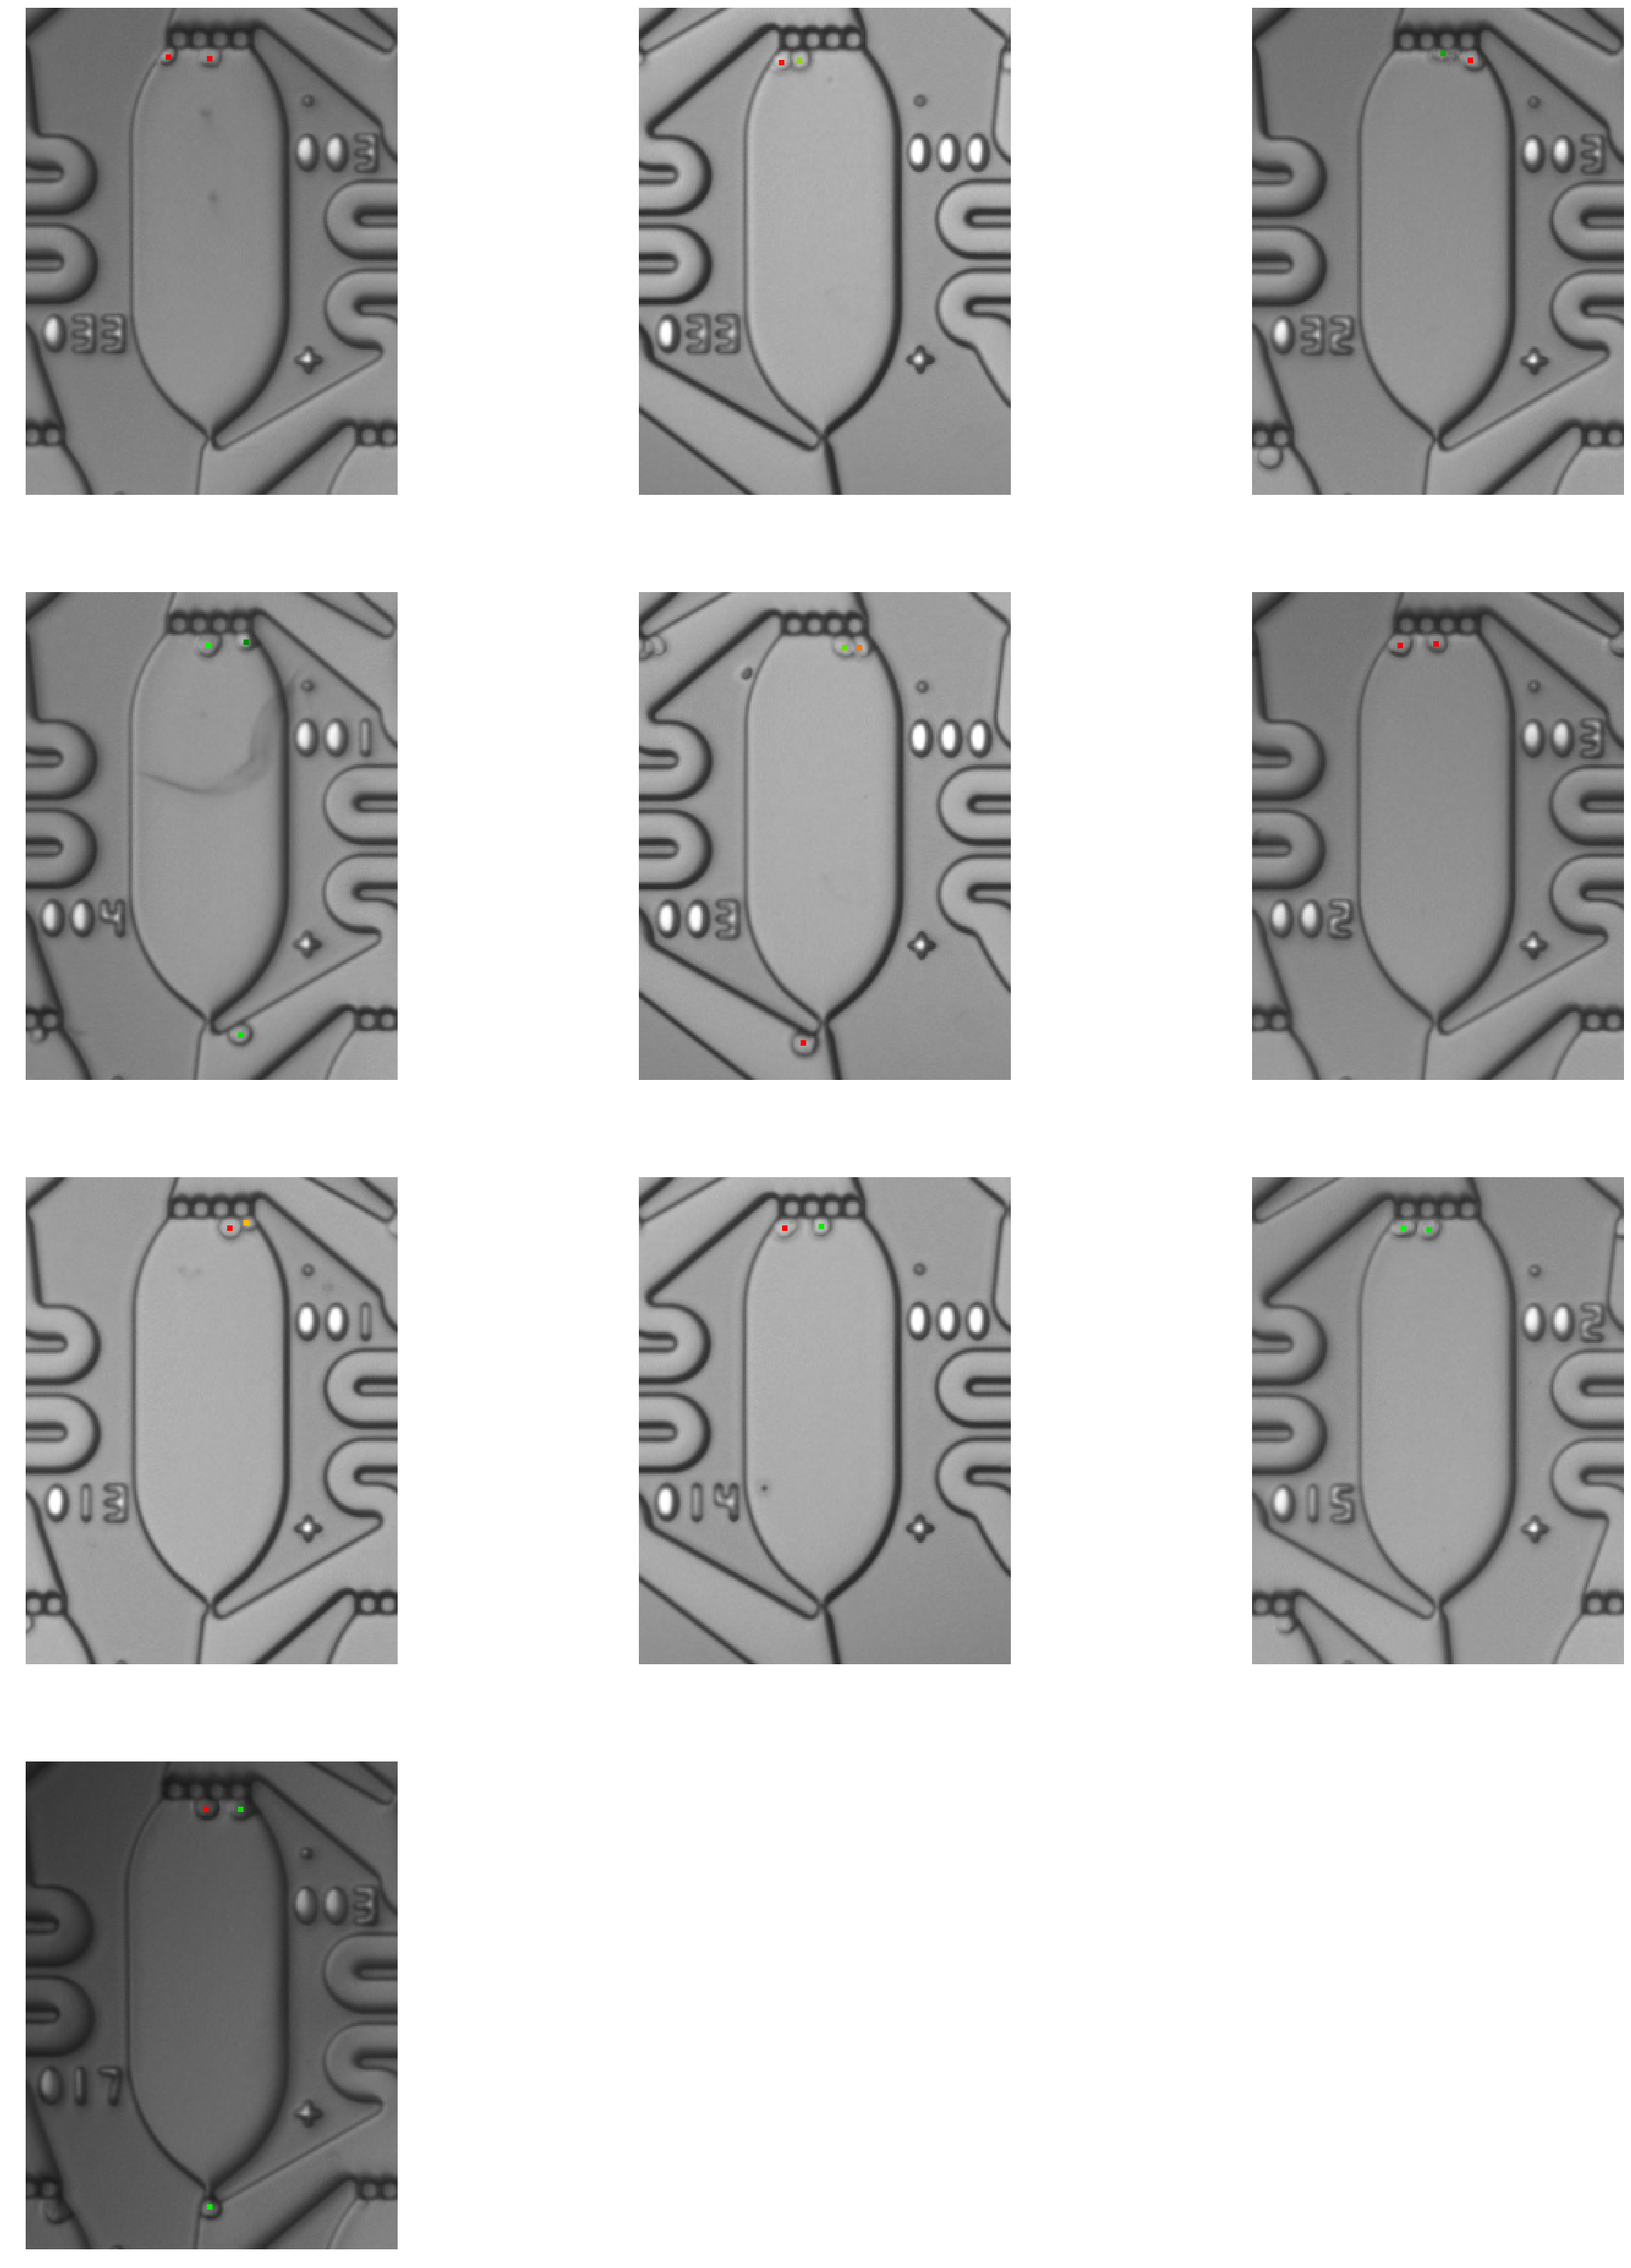

In [49]:
display_images(df['image'], size=40, cols=3)

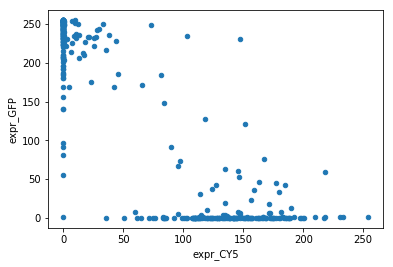

In [13]:
df.plot(kind='scatter', x='expr_CY5', y='expr_GFP')